In [1]:
# !curl http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip -o pokemon.zip #downloading zip file
# !unzip pokemon.zip -d /content/  # unzipping it

In [4]:
import os
import time
import torch
import zipfile
import warnings
import requests
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.layer1 = nn.ConvTranspose2d(in_channels=100, out_channels=512,kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=512)
        self.activation1 = nn.ReLU()

        self.layer3 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        self.activation3 = nn.ReLU()

        self.layer4 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(num_features=128)
        self.activation4 = nn.ReLU()

        self.layer5 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1)
        self.batch_norm5 = nn.BatchNorm2d(num_features=64)
        self.activation5 = nn.ReLU()

        self.lastlayer = nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1)
        self.activation = nn.Tanh()

    def forward(self, X):
        out = self.activation1(self.batch_norm1(self.layer1(X)))
        out = self.activation3(self.batch_norm3(self.layer3(out)))
        out = self.activation4(self.batch_norm4(self.layer4(out)))
        out = self.activation5(self.batch_norm5(self.layer5(out)))
        out = self.activation(self.lastlayer(out))

        return out


In [7]:
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchnorm1 = nn.BatchNorm2d(num_features=64)
        self.activation1 = nn.LeakyReLU(0.2,inplace=True)

        self.layer2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(num_features=128)
        self.activation2 = nn.LeakyReLU(0.2,inplace=True)

        self.layer3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchnorm3 = nn.BatchNorm2d(num_features=256)
        self.activation3 = nn.LeakyReLU(0.2,inplace=True)

        self.layer4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(num_features=512)
        self.activation4 = nn.LeakyReLU(0.2,inplace=True)

        self.layer5 = nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=3,padding=1,bias=False)

    def forward(self, X):
        out = self.activation1(self.batchnorm1(self.layer1(X)))
        out = self.activation2(self.batchnorm2(self.layer2(out)))
        out = self.activation3(self.batchnorm3(self.layer3(out)))
        out = self.activation4(self.batchnorm4(self.layer4(out)))
        # out = self.activation5(self.lastlayer(self.layer5(out))).view(-1)
        out = self.layer5(out)
        return out

In [8]:
Discriminator = discriminator()
generator = generator()

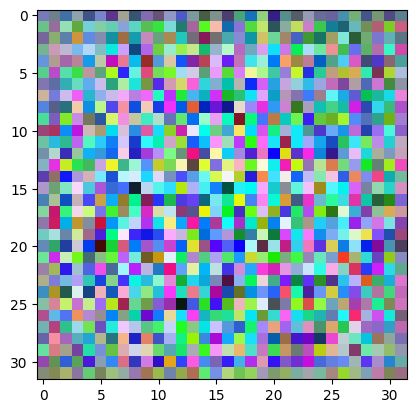

In [9]:
noise = torch.randn(1, 100, 1, 1)

fake_image = generator(noise)
fake_image = fake_image.detach().cpu()          # Move the tensor to CPU and detach from the computation graph
fake_image = fake_image.numpy()                 # Convert the tensor to a NumPy array
fake_image = (fake_image + 1) / 2               # Reshape and normalize the image (from [-1, 1] to [0, 1])

# Remove the batch dimension and rearrange the axes for plotting
fake_image = np.transpose(fake_image[0], (1, 2, 0))

plt.imshow(fake_image)
plt.show()

In [10]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(root='/kaggle/input/pokimane/pokemon',transform=transform)

In [11]:
data = DataLoader(dataset, batch_size=256, shuffle=True)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)
next(iter(data))[0].shape

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([256, 3, 64, 64])

In [12]:
def show_images(images, num_rows, num_cols, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(images[i * num_cols + j])
            axes[i, j].axes.get_xaxis().set_visible(False)
            axes[i, j].axes.get_yaxis().set_visible(False)
    return axes

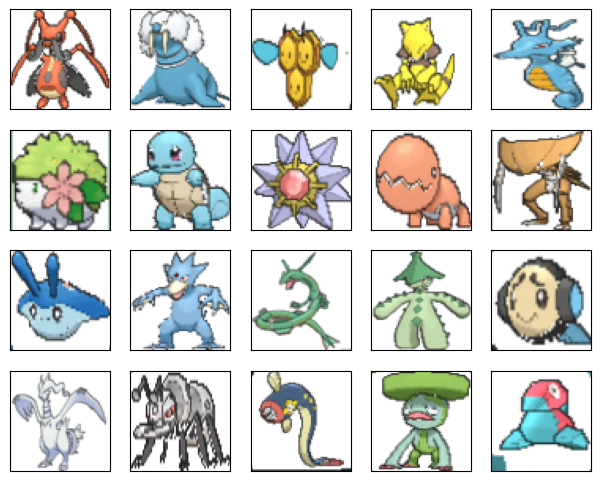

In [13]:
warnings.filterwarnings('ignore')
for X, y in data_loader:
    imgs = X[:20].permute(0, 2, 3, 1) / 2 + 0.5
    show_images(imgs, 4, 5)
    break

In [14]:
# batch = next(iter(data))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.show()

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
Discriminator.apply(weights_init)

discriminator(
  (layer1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): LeakyReLU(negative_slope=0.2, inplace=True)
  (layer2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): LeakyReLU(negative_slope=0.2, inplace=True)
  (layer3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): LeakyReLU(negative_slope=0.2, inplace=True)
  (layer4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation4): LeakyReLU(negative_slope=0.2, inpl

In [16]:
nz = 100
lr=0.0002
beta1 = 0.5
latent_dim, lr, num_epochs = 100, 0.005, 20


In [17]:
criterion = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizer_D = optim.Adam(Discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [20]:
for X,_ in data_loader:
    X = X.to(device)
    Discriminator = Discriminator.to(device)
    print(Discriminator(X))

tensor([[[[-2.4405e-02]]],


        [[[-1.7857e-02]]],


        [[[-1.4961e-02]]],


        [[[ 5.0358e-03]]],


        [[[-4.6811e-03]]],


        [[[-2.3500e-02]]],


        [[[-2.3108e-02]]],


        [[[-3.3448e-02]]],


        [[[-1.4470e-02]]],


        [[[-1.5042e-02]]],


        [[[-7.8106e-03]]],


        [[[-7.6087e-03]]],


        [[[-2.6997e-02]]],


        [[[-1.3156e-02]]],


        [[[-5.4344e-02]]],


        [[[ 1.3661e-02]]],


        [[[-1.4611e-02]]],


        [[[-2.0802e-02]]],


        [[[ 9.3938e-04]]],


        [[[-6.7035e-03]]],


        [[[-1.8211e-03]]],


        [[[ 6.3838e-04]]],


        [[[-1.8858e-02]]],


        [[[ 8.1732e-03]]],


        [[[ 7.1985e-03]]],


        [[[-2.0251e-02]]],


        [[[-1.9683e-02]]],


        [[[-2.3921e-02]]],


        [[[-6.8665e-03]]],


        [[[-1.8374e-02]]],


        [[[ 2.2355e-03]]],


        [[[-2.3334e-02]]],


        [[[-1.4012e-02]]],


        [[[-2.7825e-03]]],


        [[[-1.

KeyboardInterrupt: 

epoch 1, loss_D 0.000, loss_G 0.000, time 59.96 sec
epoch 2, loss_D 0.000, loss_G 0.000, time 59.72 sec
epoch 3, loss_D 0.000, loss_G 0.000, time 60.03 sec
epoch 4, loss_D 0.000, loss_G 0.000, time 59.75 sec
epoch 5, loss_D 0.000, loss_G 0.000, time 59.42 sec
epoch 6, loss_D 0.000, loss_G 0.000, time 59.43 sec
epoch 7, loss_D 0.000, loss_G 0.000, time 59.77 sec
epoch 8, loss_D 0.000, loss_G 0.000, time 61.22 sec
epoch 9, loss_D 0.000, loss_G 0.000, time 61.07 sec
epoch 10, loss_D 0.000, loss_G 0.000, time 61.12 sec
epoch 11, loss_D 0.000, loss_G 0.000, time 60.86 sec
epoch 12, loss_D 0.000, loss_G 0.000, time 64.62 sec
epoch 13, loss_D 0.000, loss_G 0.000, time 62.14 sec
epoch 14, loss_D 0.000, loss_G 0.000, time 66.07 sec
epoch 15, loss_D 0.000, loss_G 0.000, time 64.56 sec
epoch 16, loss_D 0.000, loss_G 0.000, time 62.17 sec
epoch 17, loss_D 0.000, loss_G 0.000, time 63.27 sec
epoch 18, loss_D 0.000, loss_G 0.000, time 63.78 sec
epoch 19, loss_D 0.000, loss_G 0.000, time 62.84 sec
ep

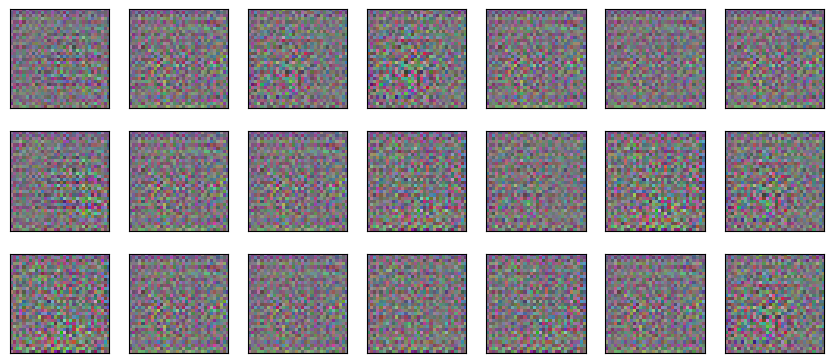

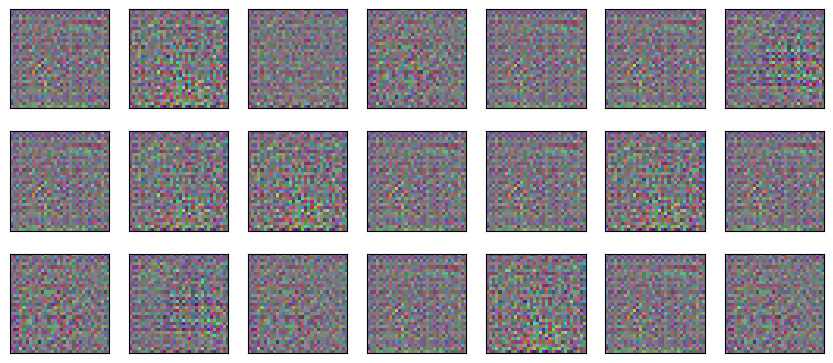

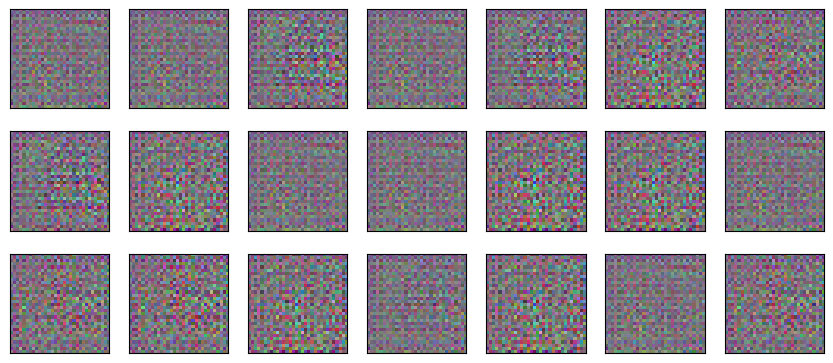

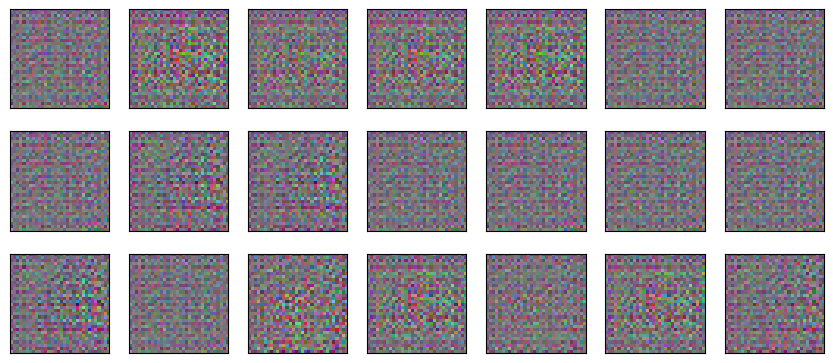

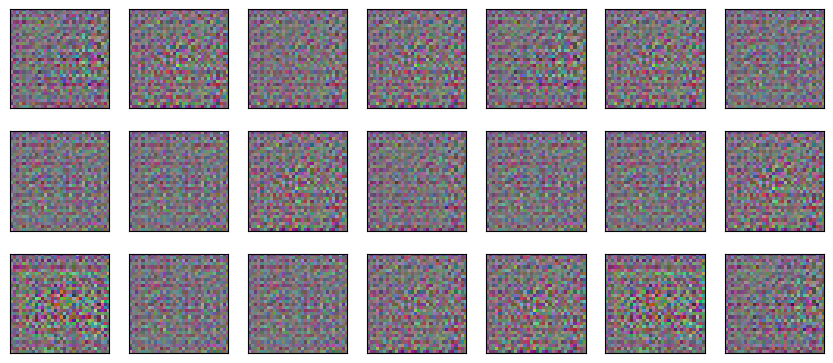

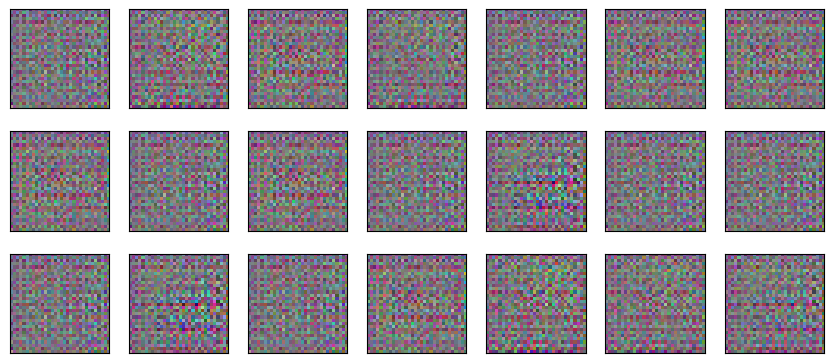

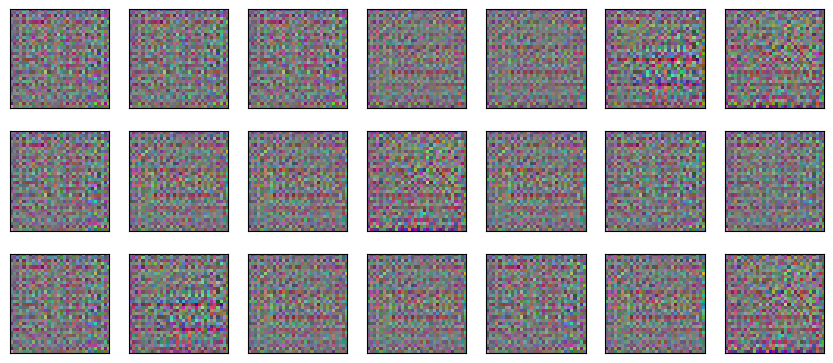

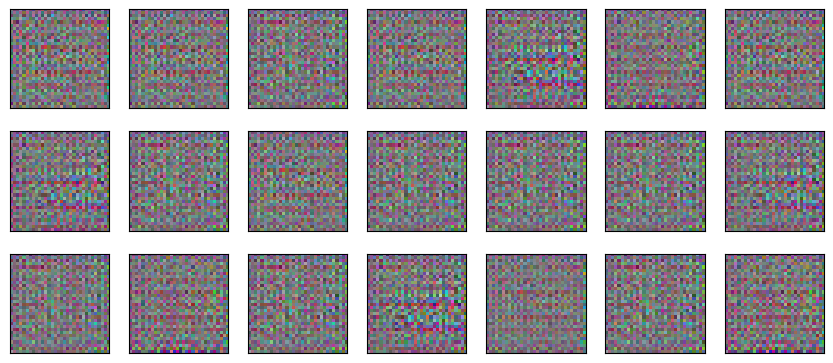

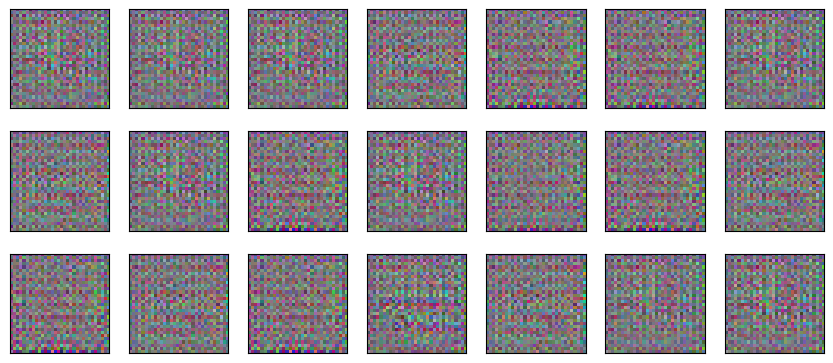

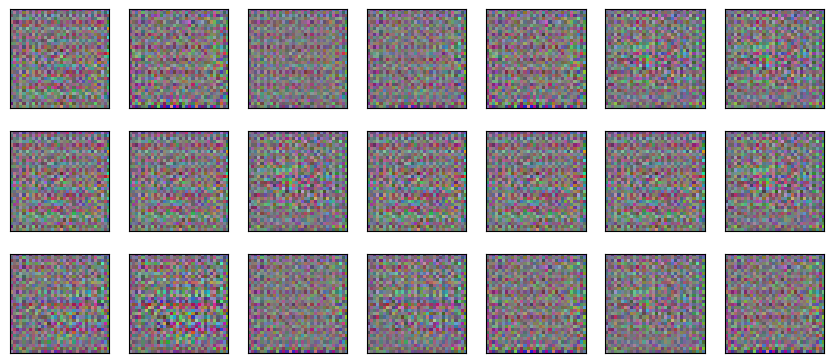

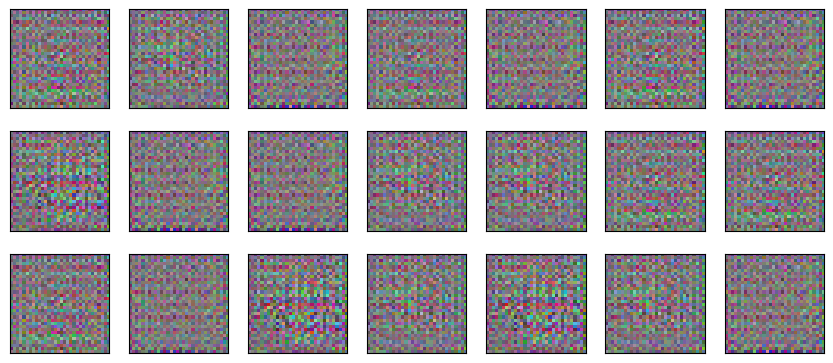

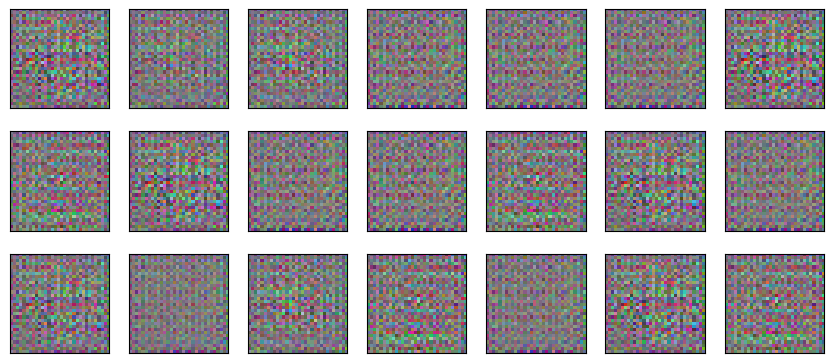

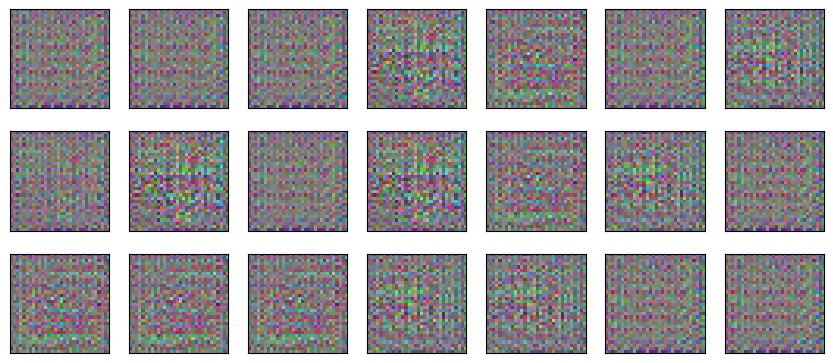

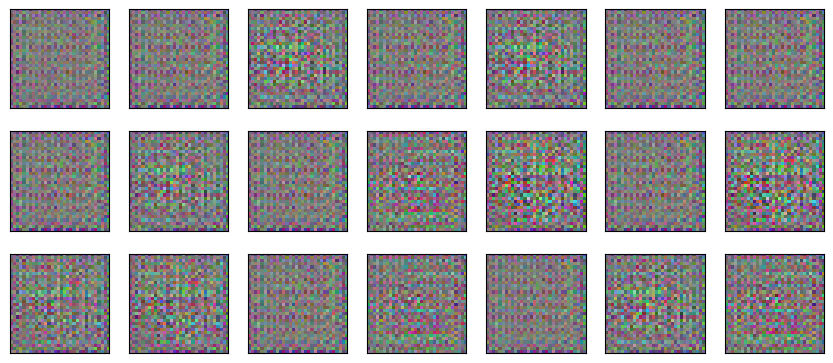

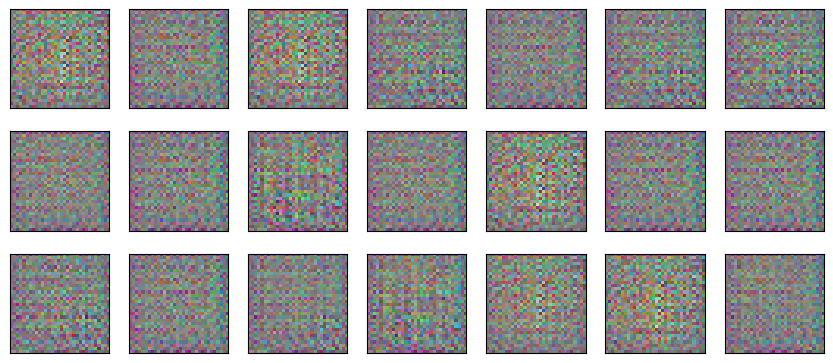

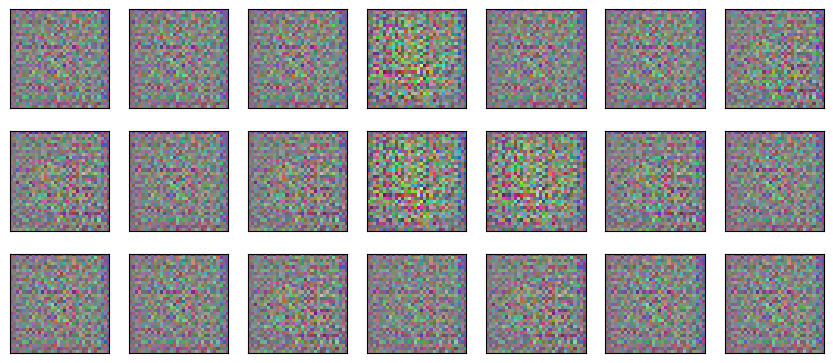

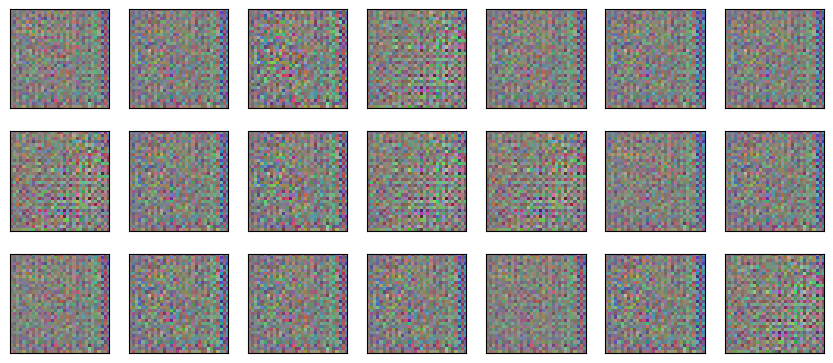

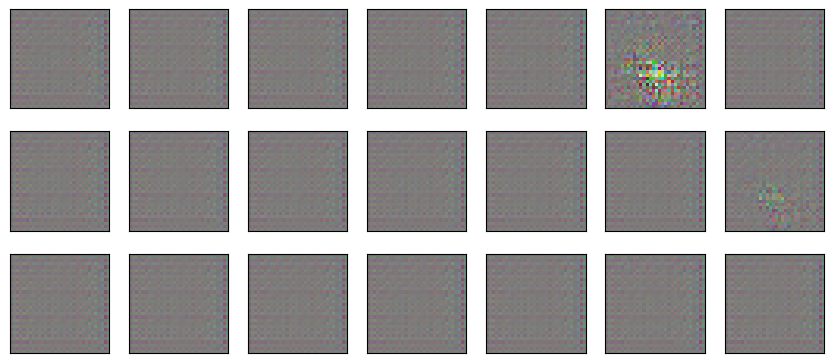

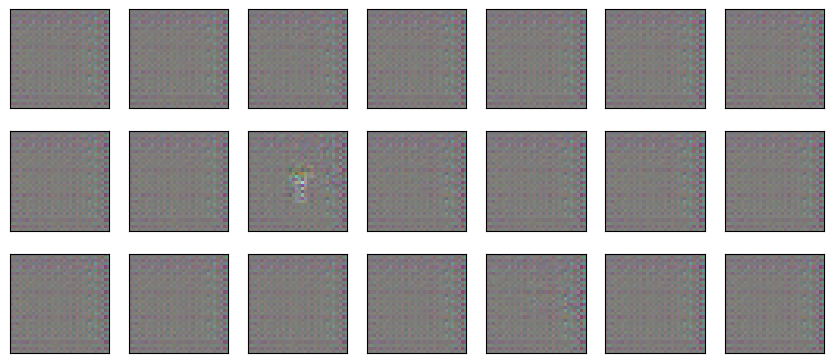

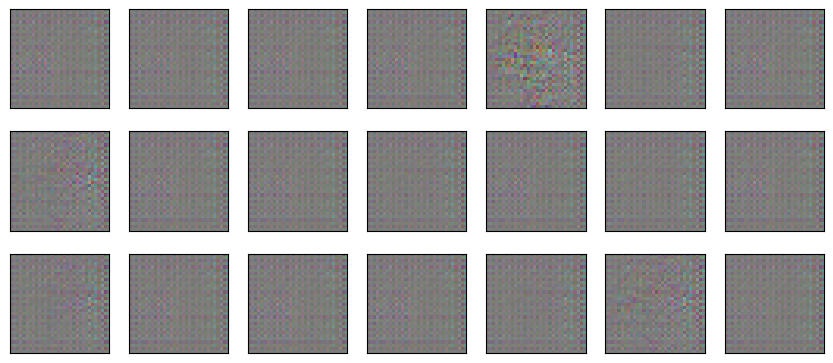

In [30]:
Discriminator.to(device)
generator.to(device)
n=0
for epoch in range(1,num_epochs+1):
    loss_D,loss_G = 0,0
    start_time = time.time()
    for X, _ in data_loader:
        
        batch_size = X.shape[0]
        Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1)).to(device)
        X = X.to(device)        
        true_label = torch.ones(batch_size, device=device)
        fake_label = torch.zeros(batch_size, device=device)
        real_Y = Discriminator(X).view(-1)
        loss_real_D = criterion(real_Y,true_label)
        fake_data = generator(Z)
        fake_Y = Discriminator(fake_data.detach()).view(-1)
        loss_fake_Y = criterion(fake_Y,fake_label)
        loss_D = (loss_real_D + loss_fake_Y) / 2
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()        
        
        n += batch_size
        batch_size = Z.shape[0]
        true_label = torch.ones(batch_size, device=device)
        fake_img = generator(Z)
        fake_Y = Discriminator(fake_img).view(-1)
        loss_G = criterion(fake_Y, true_label)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        end_time = time.time()
    print(f'epoch {epoch}, loss_D {loss_D / n:.3f}, loss_G {loss_G/ n:.3f}, time {end_time - start_time:.2f} sec')

    # Display generated images
    with torch.no_grad():
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        fake_X = generator(Z).permute(0, 2, 3, 1).cpu() / 2 + 0.5
        fake_X = fake_X.clamp(0, 1)
        show_images(fake_X, 3, 7)
      

In [ ]:
# plt.figure(figsize=(10,5))
# plt.title("Generator and Discriminator Loss During Training")
# plt.plot(G_losses,label="G")
# plt.plot(D_losses,label="D")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

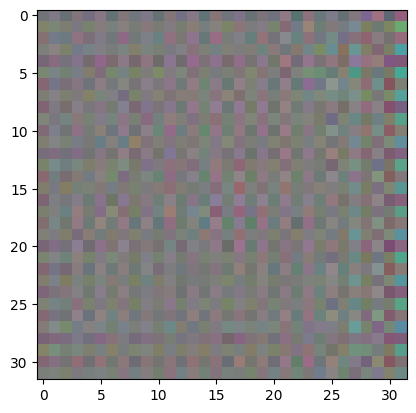

In [32]:
noise = noise.to(device)
fake_image = generator(noise)
fake_image = fake_image.detach().cpu()          # Move the tensor to CPU and detach from the computation graph
fake_image = fake_image.numpy()                 # Convert the tensor to a NumPy array
fake_image = (fake_image + 1) / 2               # Reshape and normalize the image (from [-1, 1] to [0, 1])

# Remove the batch dimension and rearrange the axes for plotting
fake_image = np.transpose(fake_image[0], (1, 2, 0))

plt.imshow(fake_image)
plt.show()